# BlenderSpike demo

## CA1 pyramidal cell activation

This notebook uses the CA1 neuron model publicly available from [modeldb](https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=55035#tabs-1)

The code for the Migliore2005 model is provided in this directory for reproducibility

**Note:** The `Migliore2005` directory also contains a modified `Initialize_cell.hoc`, which loads the morphology and sets up the biophysics, but doesn't run any simulations

In [ ]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

h.nrn_load_dll("Migliore2005/arm64/libnrnmech.dylib")
h.load_file("Migliore2005/Initialize_cell.hoc")
h('objref nil')

import sys
sys.path.append("../../")
import blenderspike_py

## Loading the model and scattering synapses

In [3]:
class Pyramidal:
    # All sections are loaded when calling h.load_file("Migliore2005/Initialize_cell.hoc") in the first cell
    # This is for the use of reference only
    def __init__(self):
        self.all = list(h.allsec())
        self.soma = self.all[1]
        self.axon = self.all[0]
        self.dends = self.all[2:]

cell = Pyramidal()

In [4]:
def add_AMPAsyns(model, locs=[[0, 0.5]], gmax=0.5, tau1=0.5, tau2=1):
    model.AMPAlist = []
    model.ncAMPAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc in locs:
        AMPA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])]) 
        AMPA.tau1 = tau1
        AMPA.tau2 = tau2
        NC = h.NetCon(h.nil, AMPA, 0, 0, gmax)
        model.AMPAlist.append(AMPA)
        model.ncAMPAlist.append(NC)

        
def add_NMDAsyns(model, locs=[[0, 0.5]], gmax=0.5, tau1=2, tau2=20):
    model.NMDAlist = []
    model.ncNMDAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc in locs:
        NMDA = h.Exp2SynNMDA(float(loc[1]), sec=model.dends[int(loc[0])]) 
        NMDA.tau1 = tau1
        NMDA.tau2 = tau2
        NC = h.NetCon(h.nil, NMDA, 0, 0, gmax)
        x = float(loc[1])
        model.NMDAlist.append(NMDA)
        model.ncNMDAlist.append(NC)   

def add_GABAsyns(model, locs=[[0, 0.5]], gmax=0.5, tau1=0.1, tau2=4,
                     rev=-75):
    model.GABAlist = []
    model.ncGABAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc in locs:
        GABA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])]) 
        GABA.tau1 = tau1
        GABA.tau2 = tau2
        GABA.e = rev
        NC = h.NetCon(h.nil, GABA, 0, 0, gmax)
        model.GABAlist.append(GABA)
        model.ncGABAlist.append(NC)
        
        
def genRandomLocs(model, nsyn):
    '''Random locations along dendrites for synapses'''
    locs = []
    for s in np.arange(0,nsyn):
        dend = np.random.randint(low=0, high=len(model.dends))
        pos = np.random.uniform()
        locs.append([dend, pos])
    return locs

def assign_spikes_to_NetCon(NC_object, spiketimes):
    for time in spiketimes:
        NC_object.event(time)
        
def assign_spiketrains_to_synapses(NC_list, spiketrains):
    for i in range(len(NC_list)):
        assign_spikes_to_NetCon(NC_list[i], spiketrains[i])
        
class SpikeManager():
    '''Container class for spike train information'''
    def __init__(self, cell):
        self.cell = cell
        self.AMPA_spiketrains = None
        self.NMDA_spiketrains = None
        self.GABA_spiketrains = None
        
    def init_spikes(self):
        if self.AMPA_spiketrains is not None:
            assign_spiketrains_to_synapses(self.cell.ncAMPAlist, self.AMPA_spiketrains)
        if self.NMDA_spiketrains is not None:
            assign_spiketrains_to_synapses(self.cell.ncNMDAlist, self.NMDA_spiketrains)
        if self.GABA_spiketrains is not None:
            assign_spiketrains_to_synapses(self.cell.ncGABAlist, self.GABA_spiketrains)
            
    def plot_spiketrains(self, ax=None):
        if self.AMPA_spiketrains is not None:
            AMPA_N = len(self.AMPA_spiketrains)
            if ax is None:
                fig, ax = plt.subplots(1,1,figsize=(20,AMPA_N*0.5),dpi=200)
                #ax.axis(False)
            for i in range(AMPA_N):
                ax.eventplot(self.AMPA_spiketrains[i], linelengths=0.5, lineoffsets=i)
                
        if self.NMDA_spiketrains is not None:
            NMDA_N = len(self.NMDA_spiketrains)
            if ax is None:
                fig, ax = plt.subplots(1,1,figsize=(20,NMDA_N*0.5),dpi=200)
                #ax.axis(False)
            for i in range(NMDA_N):
                ax.eventplot(self.NMDA_spiketrains[i], linelengths=0.5, lineoffsets=i+AMPA_N,color="red")

In [5]:
def gauss(mu, sigma, amp):
    return lambda t: amp*np.exp((-((t-mu)/sigma)**2/2))

def Poisson_homogenious_spikes(t_start, t_stop, rate):
    times= np.cumsum(np.random.exponential(1/rate,int(t_stop*rate*2)))
    return times[(times>=t_start)&(times<=t_stop)]
        
def Poisson_Gaussian_spikes(t_start, t_stop, peak_rate, mu, sigma):
    return nhpp.get_arrivals(knots={t_start:2*peak_rate, t_stop:2*peak_rate}, func=gauss(mu, sigma, peak_rate))

In [6]:
sm = SpikeManager(cell=cell) # Creating a SpikeManager instance

GLOBAL_T_STOP = 500

## --- AMPA synapses 
AMPA_N = 500
AMPA_Tstart = 0
AMPA_Tstop = GLOBAL_T_STOP
AMPA_rate = 0.0022
AMPA_gmax=1
AMPA_tau1=0.1
AMPA_tau2=4


Elocs = genRandomLocs(cell,AMPA_N) # Scattering excitatory synapses
add_AMPAsyns(cell, Elocs, AMPA_gmax,AMPA_tau1,AMPA_tau2 )
sm.AMPA_spiketrains = [Poisson_homogenious_spikes(AMPA_Tstart, AMPA_Tstop,AMPA_rate) for i in range(len(Elocs))]

## --- GABA synapses 
GABA_N = 60
GABA_Tstart = 0
GABA_Tstop = GLOBAL_T_STOP
GABA_rate = 0.008
GABA_gmax=4
GABA_tau1=0.1
GABA_tau2=4

Ilocs = genRandomLocs(cell, GABA_N) # Scattering inhibitory synapses
add_GABAsyns(cell, Ilocs,GABA_gmax,GABA_tau1, GABA_tau2)
sm.GABA_spiketrains = [Poisson_homogenious_spikes(GABA_Tstart,GABA_Tstop, GABA_rate) for i in range(len(Ilocs))]

## Running the simulation

In [7]:
def simulate(model, spikeManager, t_stop=200, dt=0.02):
    h.dt = dt
    trec = h.Vector()
    model.recorder = blenderspike_py.CellRecorder(model.all, dt=dt)
    trec.record(h._ref_t)
    
    print("Running a simulation with duration %sms (dt: %sms)"%(t_stop,h.dt))
    fih = h.FInitializeHandler(1, spikeManager.init_spikes)
    h.finitialize(-60)
    h.continuerun(t_stop)

In [8]:
simulate(cell, sm)

Running a simulation with duration 200ms (dt: 0.02ms)


## Visualizing the results

The blenderspike_py.CellRecorder instance can be accessed from `cell.recorder`, where `cell` is the `Pyramidal()` object we created earlier

In [10]:

print(f"The CellRecorder has {len(cell.recorder.monitors)} SectionMonitors corresponding to each of {len(cell.all)} sections")

cell.all[:20]

The CellRecorder has 173 SectionMonitors corresponding to each of 173 sections


[axon[0],
 soma[0],
 dendrite[0],
 dendrite[1],
 dendrite[2],
 dendrite[3],
 dendrite[4],
 dendrite[5],
 dendrite[6],
 dendrite[7],
 dendrite[8],
 dendrite[9],
 dendrite[10],
 dendrite[11],
 dendrite[12],
 dendrite[13],
 dendrite[14],
 dendrite[15],
 dendrite[16],
 dendrite[17]]

In [11]:
import seaborn as sns

Text(0.5, 1.0, 'Dendrite voltages (section 40)')

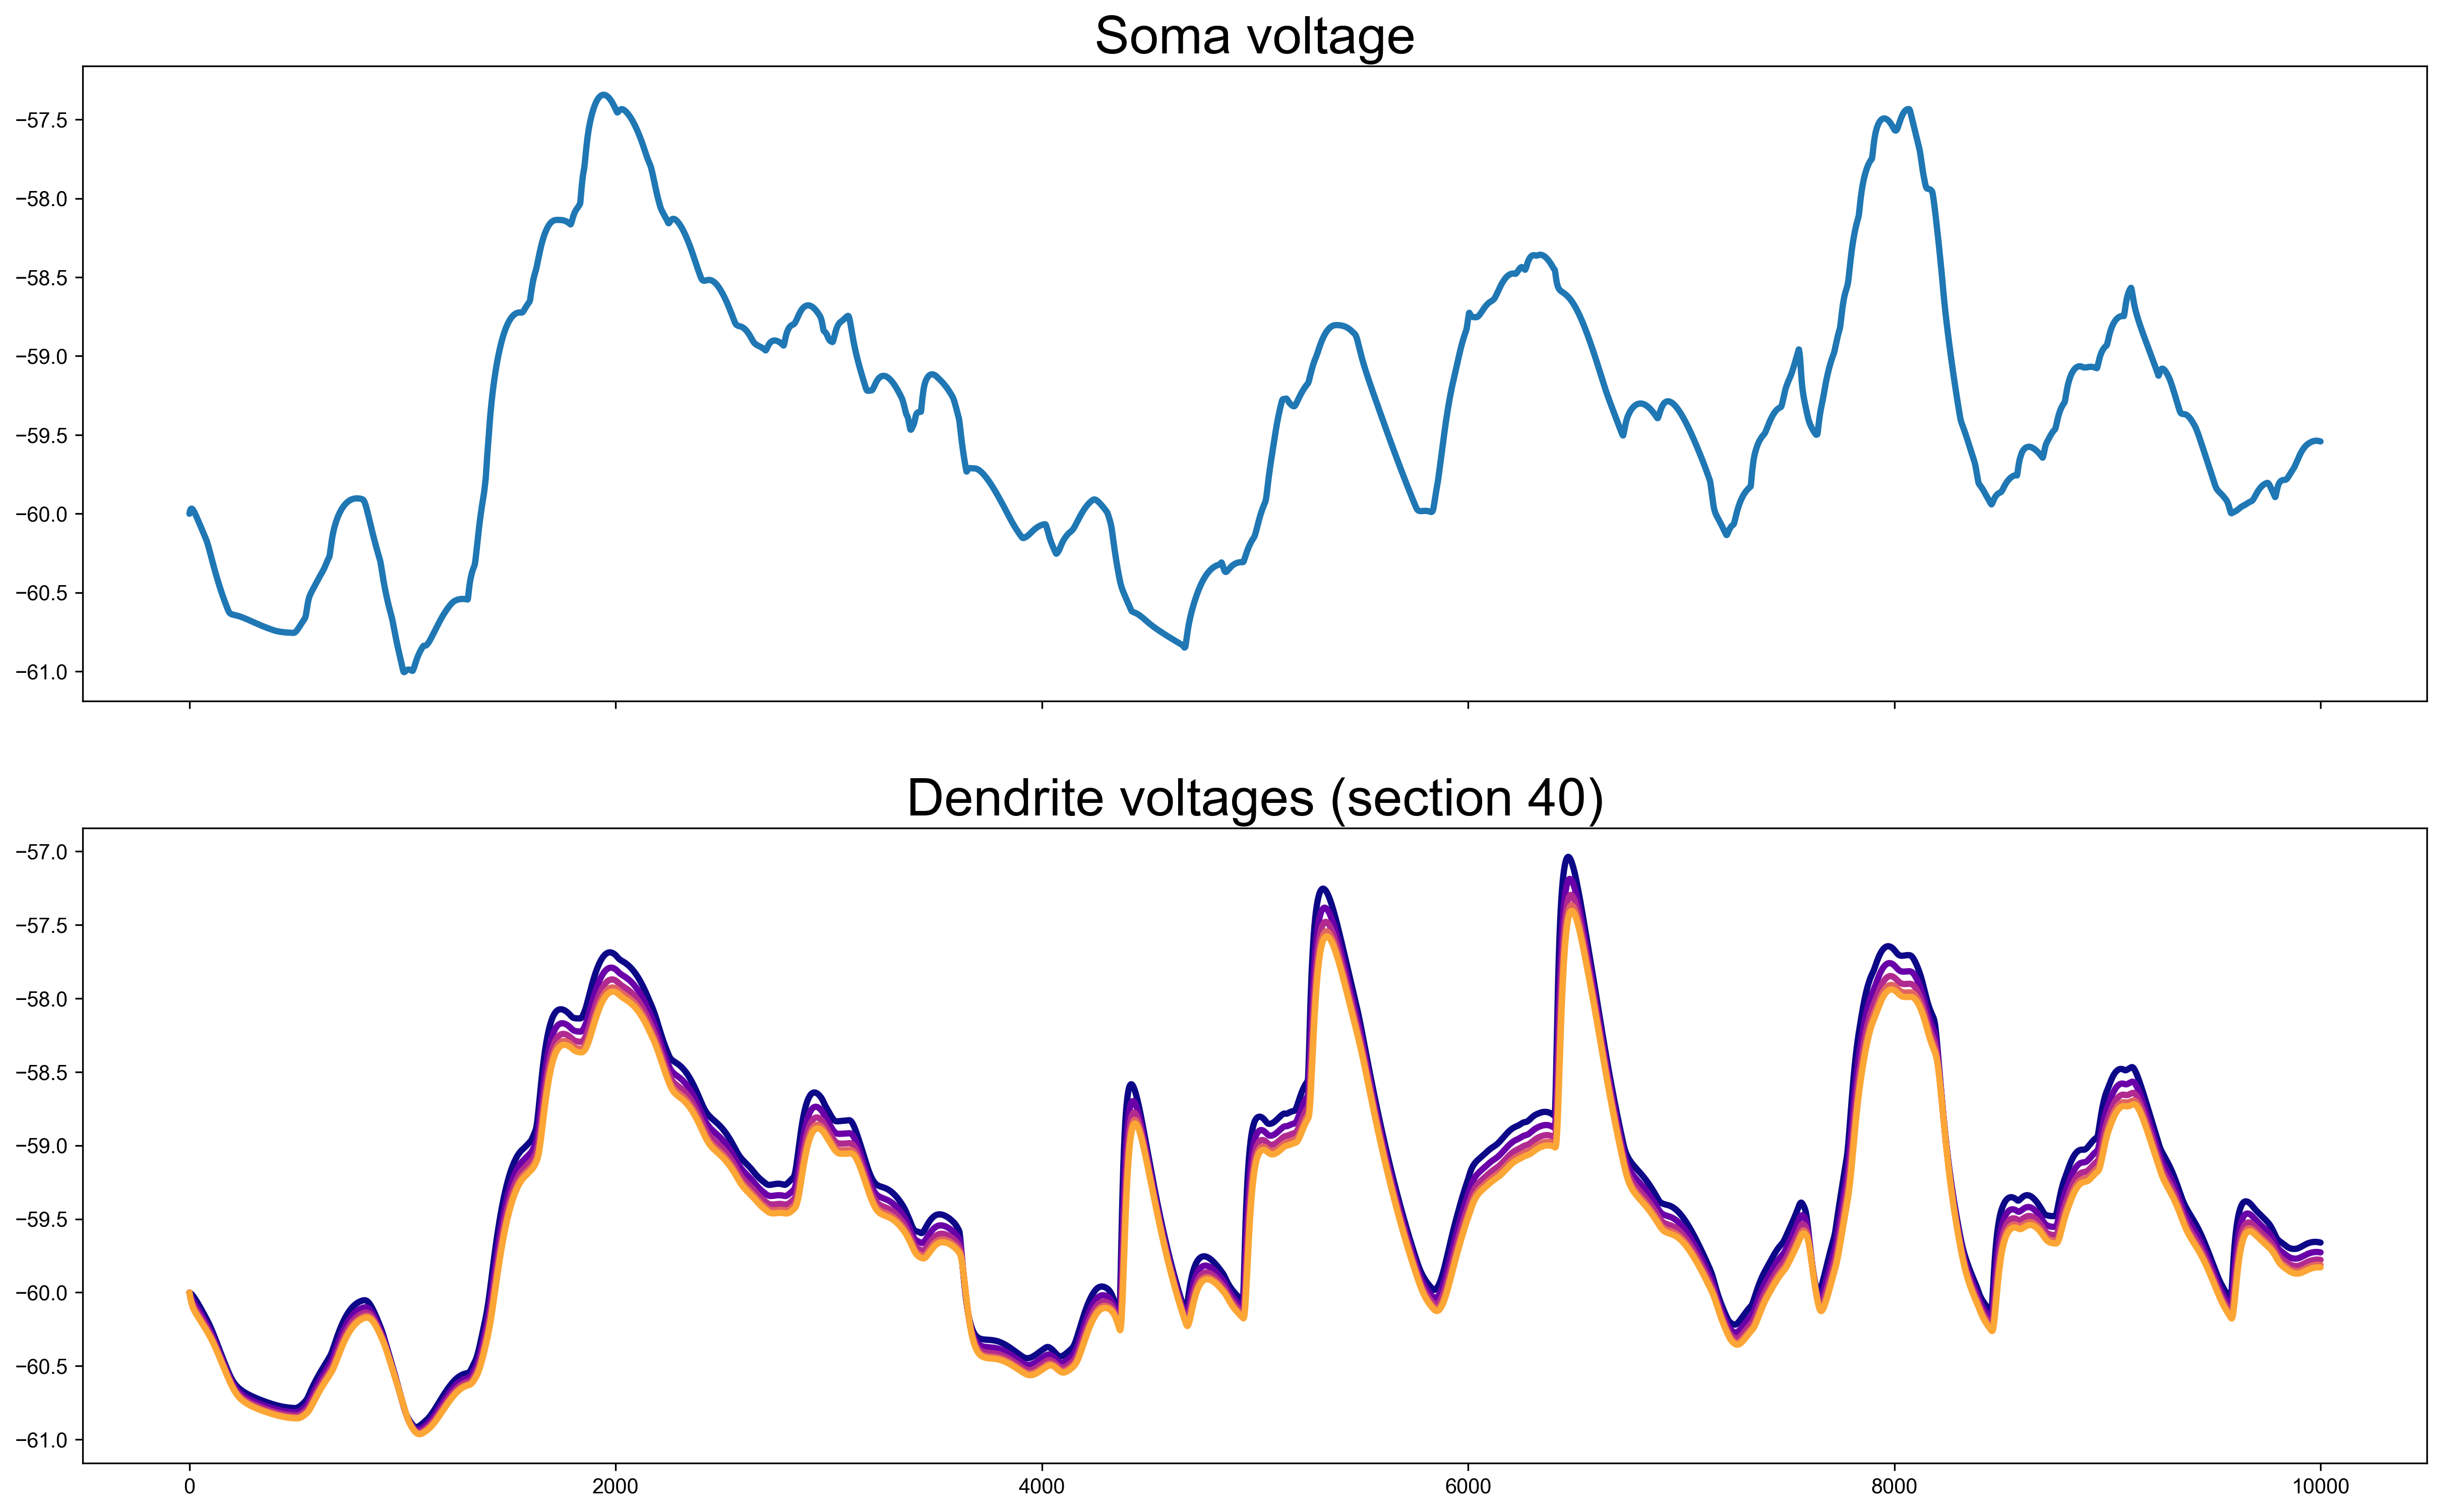

In [12]:
fig, axs = plt.subplots(2,1,figsize=(20,12),dpi=300, sharex=True)
sns.set_style("dark")
# Soma (#section = 1)
soma_monitor = cell.recorder.monitors[1]
axs[0].plot(soma_monitor.Vectors[0], lw=3)
axs[0].set_title("Soma voltage", fontsize=25)

dendrite_monitor = cell.recorder.monitors[40]
for k,vector in enumerate(dendrite_monitor.Vectors):
    axs[1].plot(vector, lw=3, color=plt.cm.plasma(k/len(dendrite_monitor.Vectors)))
axs[1].set_title("Dendrite voltages (section 40)", fontsize=25)


## Brining the model to Blender

- `FRAME_NUM` – number of frames on Blender timeline our animation should occupy (interpolation will be performed)

In [13]:
cell.recorder.save_pickle("CA1 random input.pickle",FRAME_NUM = 500)

<img src="../../assets/Blender interface – CA1 random input.png">

## Resulting animation ✨

<img src="../../assets/demo animations/CA1 random input demo animation.gif">